In [21]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import scipy.sparse
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
from gensim.models.phrases import Phrases, Phraser
import gensim.downloader as gensim_api

nltk.download("omw-1.4")

FILE_NAME = "covid19_articles_20201231.csv"


[nltk_data] Downloading package omw-1.4 to /Users/sherman/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = pd.read_csv("data/" + FILE_NAME)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]


In [3]:
## REMOVE THIS LINE FOR PROD ##
## USED FOR TESTING TO MAKE THINGS FASTER ##
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, stratify=y, random_state=69)
X = X_test[["content"]]
y = y_test
X_train, X_test, y_train, y_test = None, None, None, None
## END ##


In [4]:
def clean_text(text, stemm=False, lemm=False, stopwords=None):
    text = re.sub(r"[^a-z\s]", "", text.lower().strip())
    if stopwords:
        text = [x for x in text.split() if x not in stopwords]

    if stemm:
        stemmer = PorterStemmer()
        text = [stemmer.stem(x) for x in text]

    if lemm:
        lemmatizer = WordNetLemmatizer()
        text = [lemmatizer.lemmatize(x) for x in text]

    return " ".join(text)


STOP_WORDS = set(nltk.corpus.stopwords.words("english"))


In [5]:
X["clean"] = X["content"].apply(
    lambda x: clean_text(x, lemm=True, stopwords=STOP_WORDS)
)


# TFIDF Vectors


In [6]:
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    max_features=10000, ngram_range=(1, 2)
)

tfidf_corpus = X["clean"]
tfidf_vectors = tfidf_vectorizer.fit_transform(tfidf_corpus)
tfidf_vocab = tfidf_vectorizer.vocabulary_

print(tfidf_vectors.shape)


(18453, 10000)


In [7]:
## reduce dimensionality by using Chi-Square test
## generate most significant words
tfidf_X_names = tfidf_vectorizer.get_feature_names_out()
p_value_limit = 0.95

_ = pd.DataFrame()
for category in np.unique(y):
    chi_square, p = chi2(tfidf_vectors, y == category)
    _ = pd.concat(
        [_, pd.DataFrame({"feature": tfidf_X_names, "score": 1 - p, "y": category})]
    )
    _ = _.sort_values(["y", "score"], ascending=[True, False])
    _ = _[_["score"] > p_value_limit]

tfidf_X_names = _["feature"].unique().tolist()


In [8]:
## regenerate vectors
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    vocabulary=tfidf_X_names
)

tfidf_corpus = X["clean"]
tfidf_vectors = tfidf_vectorizer.fit_transform(tfidf_corpus)
tfidf_vocab = tfidf_vectorizer.vocabulary_

print(tfidf_vectors.shape)


(18453, 2443)


In [9]:
## save it for future use
scipy.sparse.save_npz("processed_data/tfidf_sparse_matrix", tfidf_vectors)
tfidf_vectors = scipy.sparse.load_npz("processed_data/tfidf_sparse_matrix.npz")
tfidf_vectors.shape


(18453, 2443)

# Word Embeddings (construct our own)

can just use `nlp = gensim_api.load("word2vec-google-news-300")`


In [10]:
we_corpus = X["clean"]

# unigrams
_ = []
for row in we_corpus:
    _.append(row.split())
we_corpus = _

bigram_phraser = Phraser(Phrases(we_corpus, delimiter=" ", min_count=5, threshold=10))



In [11]:
b_set = set()
for row in we_corpus:
    for word in bigram_phraser[row]:
        if " " in word:
            b_set.add(word)
print(list(b_set)[:10])


['former aide', 'statement guarantee', 'de juniac', 'chargeability anomaly', 'believed reliable', 'editing david', 'canopy river', 'buy hold', 'determinant health', 'making progress']


In [12]:
nlp = gensim.models.word2vec.Word2Vec(
    we_corpus, vector_size=300, window=8, min_count=1, sg=1, epochs=5
)


In [18]:
nlp.wv["former"][:10]

array([ 0.14432782,  0.00791636, -0.23241323, -0.6125403 , -0.41220877,
        0.2836435 ,  0.17396228,  0.05159114,  0.1892883 , -0.5275858 ],
      dtype=float32)

In [19]:
WORD_EMBEDDINGS_FILEPATH = "processed_data/local_word_embeddings.model"
nlp.save(WORD_EMBEDDINGS_FILEPATH)
nlp = gensim.models.Word2Vec.load(WORD_EMBEDDINGS_FILEPATH)
nlp.wv["former"][:10]


array([ 0.14432782,  0.00791636, -0.23241323, -0.6125403 , -0.41220877,
        0.2836435 ,  0.17396228,  0.05159114,  0.1892883 , -0.5275858 ],
      dtype=float32)

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/var/folders/k3/j42_pl713ll6h7jgr35bjjnr0000gn/T/ipykernel_1534/3116516782.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["input"].iloc[:1] = 1


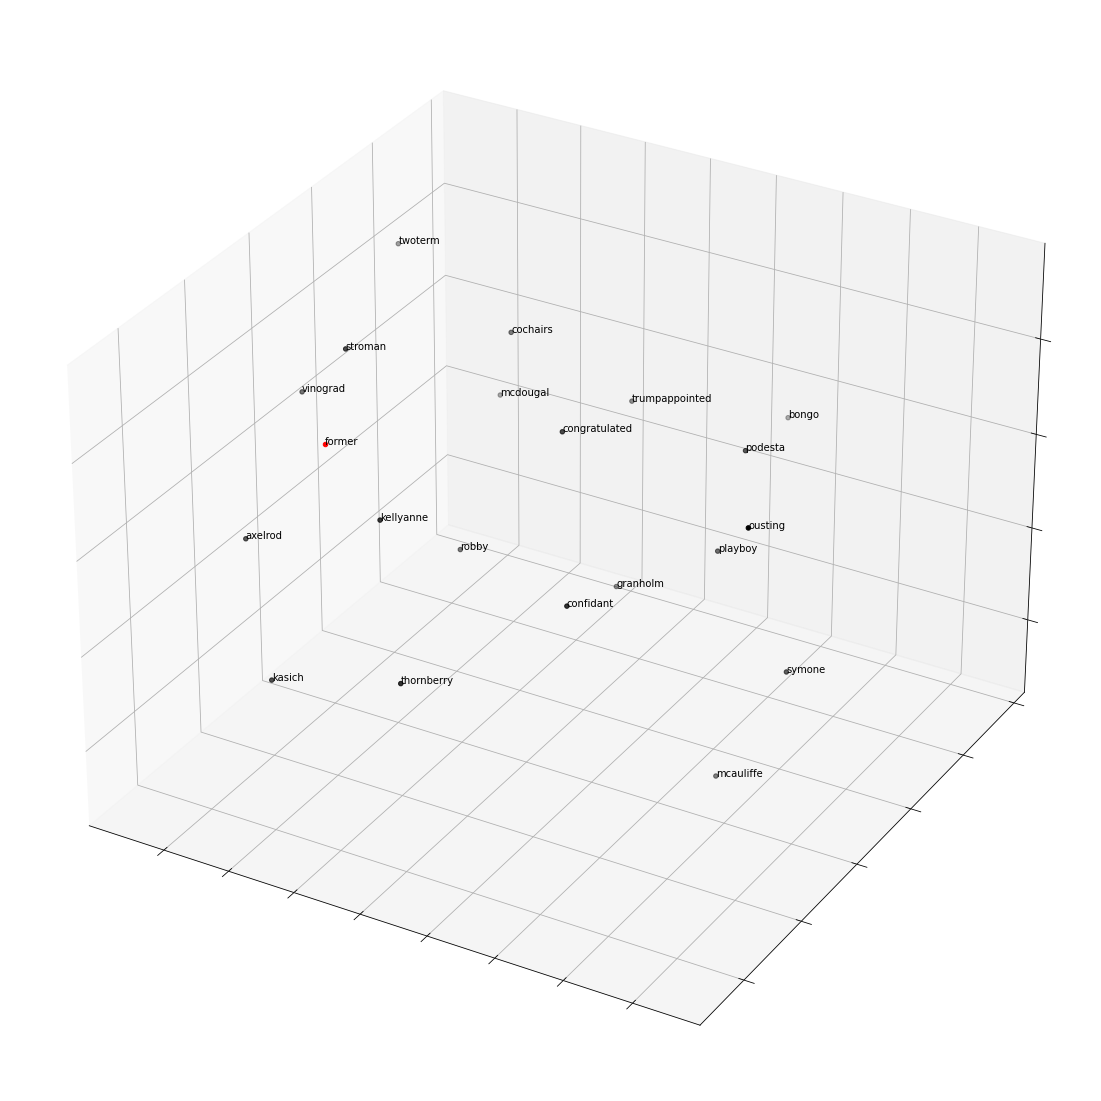

In [27]:
## similar words to "former"
word = "former"
fig = plt.figure(figsize=(20, 20))

total = [word] + [x[0] for x in nlp.wv.most_similar(word, topn=20)]
_ = nlp.wv[total]

pca = manifold.TSNE(init="pca", n_components=3)
_ = pca.fit_transform(_)

_df = pd.DataFrame(_, index=total, columns=["x", "y", "z"])
_df["input"] = 0
_df["input"].iloc[:1] = 1

ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    _df[_df["input"] == 0]["x"],
    _df[_df["input"] == 0]["y"],
    _df[_df["input"] == 0]["z"],
    c="black",
)
ax.scatter(
    _df[_df["input"] == 1]["x"],
    _df[_df["input"] == 1]["y"],
    _df[_df["input"] == 1]["z"],
    c="red",
)
ax.set(
    xlabel=None,
    ylabel=None,
    zlabel=None,
    xticklabels=[],
    yticklabels=[],
    zticklabels=[],
)
for i, row in _df[["x", "y", "z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=i)
